In [6]:
import os
import pandas as pd
import numpy as np
import time
import logging
logging.getLogger().setLevel(logging.ERROR)
print(f'Logging level: {logging.getLevelName(logging.getLogger().getEffectiveLevel())}')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import clip
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

from deep_translator import GoogleTranslator
from translate import Translator

Logging level: ERROR


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/valerio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/valerio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/valerio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
logging.getLogger().setLevel(logging.INFO)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)

In [9]:
test_images_path = 'Datasets/test_images_resized/'

In [10]:
# %%script false --no-raise-error

test_df = pd.read_csv('Datasets/data/test.csv')
test_df

,language,target_word,full_phrase,translated_target_word,translated_full_phrase,synsets_based_description_text,synsets_based_description_weight,definitions_based_description_text,definitions_based_description_weight,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10,gold_image
0,en,goal,football goal,goal,football goal,game,0.900366,ball point player attempt game place score suc...,0.862155,image.4418.jpg,image.4416.jpg,image.4417.jpg,image.4413.jpg,image.4412.jpg,image.4415.jpg,image.4419.jpg,image.4414.jpg,image.2166.jpg,image.1150.jpg,image.2166.jpg
1,en,mustard,mustard seed,mustard,mustard seed,seminal fluid sow source player come germ seeded,0.824007,small ground later future growth early outstan...,0.781248,image.4429.png,image.4422.jpg,image.4423.jpg,image.4424.jpg,image.4421.jpg,image.4427.jpg,image.4426.jpg,image.4420.jpg,image.4425.jpg,image.4428.jpg,image.4429.png
2,en,seat,eating seat,seat,eating seat,feed eat,0.877717,chair sit furniture meal food eat another place,0.856044,image.4435.jpg,image.4436.jpg,image.1166.jpg,image.4430.jpg,image.4433.jpg,image.4432.jpg,image.4438.jpg,image.4434.jpg,image.4431.jpg,image.4437.jpg,image.4432.jpg
3,en,navigate,navigate the web,navigate,navigate the web,sail www voyage entanglement world network wide,0.860221,network internet resource graphic direct text ...,0.879207,image.4439.jpg,image.4440.jpg,image.4441.jpg,image.4442.jpg,image.4444.jpg,image.4445.jpg,image.1435.jpg,image.4446.png,image.1434.jpg,image.4443.jpg,image.1435.jpg
4,en,butterball,butterball person,butterball,butterball person,somebody fatty someone fatso soul mortal fat i...,0.863288,body usually human include clothing,0.800586,image.4454.jpg,image.4450.jpg,image.4455.jpg,image.4453.jpg,image.4448.jpg,image.1253.jpg,image.4451.jpg,image.4452.jpg,image.4447.jpg,image.4449.jpg,image.4455.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,fa,شير,شير جنگل,Lion,Lion,of panthera beasts king leo,0.840985,bear feline mane predatory africa large person...,0.854452,image.3230.jpg,image.3667.jpg,image.4385.jpg,image.3672.jpg,image.4386.jpg,image.374.jpg,image.3668.jpg,image.3669.jpg,image.3671.jpg,image.3673.jpg,image.374.jpg
964,fa,کلنگ,انقراض کلنگ,pickaxe,The extinction of the pickaxe,pickax pick experimental defunctness extermina...,0.841665,annihilation existence cause remove burn reinf...,0.748596,image.4391.jpg,image.4394.jpg,image.1733.jpg,image.4387.jpg,image.4389.jpg,image.948.jpg,image.4392.jpg,image.4388.jpg,image.4390.jpg,image.4393.jpg,image.948.jpg
965,fa,صور,شكارچي صور,images,Tire hunter,bore tyre sap down wear,0.876738,hunt tired lose exhaust something bore cause s...,0.794334,image.3377.png,image.3380.png,image.3376.jpg,image.3379.jpg,image.3371.jpg,image.3378.jpg,image.3372.jpg,image.3374.jpg,image.3373.jpg,image.3375.jpg,image.3372.jpg
966,fa,پايتون,پايتون سمی,Python,poisonous python,venomous,0.857522,poison old ill quality eat large deep world,0.753567,image.4403.png,image.4396.jpg,image.4395.jpg,image.4402.jpg,image.4399.jpg,image.4401.jpg,image.4397.png,image.4398.jpg,image.814.jpg,image.4400.jpg,image.4395.jpg


## Description-based solution

### Compute cosine-similarity using CLIP

In [11]:
def compute_clip_similarity_text2text(text1, text2, model, device='cuda'):
    text1 = clip.tokenize([text1]).to(device)
    text1_features = model.encode_text(text1)

    text2 = clip.tokenize([text2]).to(device)
    text2_features = model.encode_text(text2)

    text1_features = text1_features.cpu().detach().numpy()
    text2_features = text2_features.cpu().detach().numpy()

    similarity = cosine_similarity(text1_features, text2_features)[0][0]

    return similarity

In [12]:
def compute_clip_similarity_text2image(text, image_path, model, preprocess, device='cuda'):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    text = clip.tokenize([text]).to(device)
    text_features = model.encode_text(text)

    image_features = model.encode_image(image)

    text_features = text_features.cpu().detach().numpy()
    image_features = image_features.cpu().detach().numpy()

    similarity = cosine_similarity(text_features, image_features)[0][0]

    return similarity

### Synset-base description

In [13]:
def synsets_based_description(text, model, maximum_tokens, device='cuda'):
    tokenized_text = [word.lower() for word in word_tokenize(text) if word.isalpha() and word.lower() not in stop_words]

    #* find all synsets for each word in the text and their mean_similarity with the words in tokenized text
    synonyms = []
    for word in tokenized_text:
        synsets = wn.synsets(word)
        
        if len(synsets) == 0: continue

        for syn in synsets:
            lemmas = syn.lemmas()

            if len(lemmas) == 0: continue

            for lemma in lemmas:
                lemma = lemma.name().lower()                
                tokens_lemma = lemma.split('_')   

                for token_lemma in tokens_lemma:
                    if token_lemma in tokenized_text: continue
                    total_similarity = 0
                
                    for token in tokenized_text:
                        similarity = compute_clip_similarity_text2text(token_lemma, token, model, device)
                        total_similarity += similarity
                
                    total_similarity /= len(tokenized_text)
                    synonyms.append((token_lemma, total_similarity))

    #* if there are no synonyms return an empty string and 0
    if len(synonyms) == 0: return '', 0

    #* compute the mean similarity of the synonyms and sort them by similarity
    similarity_mean = np.mean([similarity for word, similarity in synonyms])
    synonyms = sorted(synonyms, key=lambda x: x[1], reverse=True)

    print(synonyms)

    #* filter the synonyms taking only the ones with similarity > similarity_mean and then taking maximum_tokens of them
    synonyms = list(set([(word, similarity) for word, similarity in synonyms if similarity > similarity_mean][:maximum_tokens]))
    
    print(synonyms)

    #* if there are no synonyms return an empty string and 0
    if len(synonyms) == 0: return '', 0

    #* compute the description and the description_weight
    description = ' '.join([word for word, similarity in synonyms])
    description_weight = np.mean([similarity for word, similarity in synonyms])

    return description, description_weight

### Definition-based description

In [14]:
def definition_based_description(text, model, maximum_tokens, device='cuda'):
    tokenized_text = [word.lower() for word in word_tokenize(text) if word.isalpha() and word.lower() not in stop_words]

    #* find the definitions of each token in tokenized_text and compute the similarity between the definitions and the other tokens
    definitions = dict()
    for token in tokenized_text:
        synsets = wn.synsets(token)
        definitions[token] = []
        
        if len(synsets) == 0: # to avoid 'mean of empty slice' error    
            definitions[token].append(([], 0))
            continue

        for syn in synsets:
            definition = syn.definition()
            definition = list(set([nlp(word)[0].lemma_.lower() for word in word_tokenize(definition) if word not in stop_words and word.isalpha()]))
            
            if len(definition) == 0: # to avoid 'mean of empty slice' error
                definitions[token].append(([], 0))
                continue
            
            score_definition = 0
            for word in definition:
                for tok in tokenized_text:
                    similarity = compute_clip_similarity_text2text(tok, word, model, device)
                    score_definition += similarity   
            score_definition /= (len(definition)*len(tokenized_text))    
            definitions[token].append((definition, score_definition))

    #* compute the mean of the similarity of the definitions and take the definitions with a similarity score higher than the mean
    similarity_mean = np.mean([score for token in tokenized_text for definition, score in definitions[token]])
    candidate_definitions = [definition for token in tokenized_text for definition, score in definitions[token] if score > similarity_mean]

    #* take the words in the definitions that are not in the tokenized_text
    definition = list(set([word.lower() for definition in candidate_definitions for word in definition if word not in tokenized_text]))

    if len(definition) == 0: return '', 0

    #* compute the similarity between the text and the words in the definition
    description = []
    for word in definition:
        similarity = compute_clip_similarity_text2text(text, word, model, device)
        description.append((word, similarity))

    #* sort the words in the definition by similarity and take the maximum_tokens most similar
    description = sorted(description, key=lambda x: x[1], reverse=True)
    description = [(word, similarity) for word, similarity in description[:maximum_tokens]]

    #* compute the weight of the description as the mean of the similarity of the words in the description
    description_weight = np.mean([similarity for word, similarity in description])
    description = ' '.join([word for word, similarity in description])

    return description, description_weight

### Predict the images

In [15]:
def predict_image(df, index, folder_path, model, preprocess, description, translated, device='cuda'):
    start_index = df.columns.get_loc('image_1')
    end_index = df.columns.get_loc('image_10')
    candidate_images = [image for image in  df.iloc[index][start_index:end_index+1] if image == image]
    gold_image_path = folder_path + df.iloc[index]['gold_image']
    
    if translated: 
        full_phrase = (df.iloc[index]['translated_full_phrase'])
    else: 
        full_phrase = (df.iloc[index]['full_phrase'])

    if description=='synsets' or description=='definitions': 
        description_text = df.iloc[index][f'{description}_based_description_text']
        description_weight = float(df.iloc[index][f'{description}_based_description_weight'])
    elif description=='none':
        description_text   = ''
        description_weight = 0

    similarities = []
    for image in candidate_images:
        image_path = folder_path + image

        similarity_image_full_phrase = compute_clip_similarity_text2image(full_phrase, image_path, model, preprocess, device=device)
            
        if description_weight == 0: similarity_image_description = 0
        else: similarity_image_description = compute_clip_similarity_text2image(description_text, image_path, model, preprocess, device=device) 

        similarity = (1-description_weight*0.5)*similarity_image_full_phrase + description_weight*0.5*similarity_image_description

        similarities.append((image, similarity))

    most_similar_image, similarity = max(similarities, key=lambda x: x[1])
    most_similar_image_number = int(most_similar_image.split(".")[-2])

    gold_image_number = int(gold_image_path.split(".")[-2])

    if most_similar_image_number == gold_image_number: 
        return most_similar_image, similarity, True
    else:
        return most_similar_image, similarity, False

In [16]:
def predict_images(df, folder_path, model, preprocess, translated, description, device='cuda'):
    
    if translated != True and translated != False: 
        raise ValueError('translated must be a boolean value')
    
    if description not in ['synsets', 'definitions', 'none']:
        raise ValueError('description must be one of the following values: synsets, definitions, none')

    predicted_images = []

    correct = 0
    batch_correct = 0
    counter = 0
    for index in range(len(df)):

        most_similar_image, similarity, is_correct = predict_image(df, index, folder_path, model, preprocess, description, translated, device)

        if is_correct: 
            correct += 1
            batch_correct += 1
        counter += 1

        predicted_images.append(most_similar_image)

        if (index % (len(df)//10) == 0 and index != 0) or (index == len(df)-1):
            percentage = round((index/len(df))*100, 2)
            print(f' percentage: {percentage}% - accuracy: {correct/(index+1)} - accuracy of batch: {batch_correct/counter} - correct: {correct}, visited: {index+1}, total: {len(df)}')
            batch_correct = 0
            counter = 0


    accuracy = correct/len(df)
    print(f'Accuracy: {accuracy} - correct: {correct}, visited: {index+1}, total:{len(df)}') 

    return predicted_images, correct

In [17]:
def save_predicted_images(predicted_images, language, path):
    with open(f'{path}/{language}.test.preds.txt', 'w') as f:
        for item in predicted_images:
            f.write(f'{item}\n')

In [19]:
def compute_results(df, language, folder_path, model, preprocess, translated, description, device='cuda'):
    if translated != True and translated != False:
        raise ValueError('translated must be a boolean value')
    
    if description not in ['synsets', 'definitions', 'none']:
        raise ValueError('description must be one of the following values: synsets, definitions, none')

    df_language = df.query(f'language == "{language}"')
    predicted_images, correct = predict_images(df_language, folder_path, model, preprocess, translated, description, device)
    
    if translated == True and description == 'synsets':
        save_predicted_images(predicted_images, language, 'Solutions/synsets_based_solutions/preds_translated_description')
    
    elif translated == True and description == 'definitions':
        save_predicted_images(predicted_images, language, 'Solutions/definitions_based_solutions/preds_translated_description')
    
    elif translated == False and (description == 'synsets' or description == 'definitions'):
        if description == 'synsets': save_predicted_images(predicted_images, language, 'Solutions/synsets_based_solutions/preds_description')
        else: save_predicted_images(predicted_images, language, 'Solutions/definitions_based_solutions/preds_description')

    elif translated == True and description == 'none':
        save_predicted_images(predicted_images, language, 'Solutions/synsets_based_solutions/preds_translated')
        save_predicted_images(predicted_images, language, 'Solutions/definitions_based_solutions/preds_translated')

    elif translated == False and description == 'none':
        save_predicted_images(predicted_images, language, 'Solutions/synsets_based_solutions/preds')
        save_predicted_images(predicted_images, language, 'Solutions/definitions_based_solutions/preds')
    
    return correct

In [20]:
def compute_correct_predictions(pred_images, gt_images):
    pred_images_file = open(pred_images, 'r')
    pred_images = pred_images_file.readlines()
    pred_images_numbers = [int(image.split('.')[1]) for image in pred_images]

    gt_images_file = open(gt_images, 'r')
    gt_images = gt_images_file.readlines()
    gt_images_numbers = [int(image.split('.')[1]) for image in gt_images]

    correct = 0
    for i in range(len(pred_images_numbers)):
        pred = pred_images_numbers[i]
        gt = gt_images_numbers[i]
        if pred == gt: correct += 1
    return correct, len(pred_images_numbers)

### Functions to create the complete dataframe

In [18]:
%%script false --no-raise-error

columns = ['target_word', 'full_phrase'] + [f'image_{i}' for i in range(1, 11)] + ['gold_image']

en_test_data = pd.read_csv('Datasets/Test/en.test.data.txt', sep='\t', header=None)
en_test_gold = pd.read_csv('Datasets/Test/en.test.gold.txt', sep='\t', header=None)
df_en = pd.concat([en_test_data, en_test_gold], axis=1)
df_en.columns = columns
df_en.insert(0, 'language', 'en')
df_en.to_csv('Datasets/Test/new_complete_dfs/en.test.data.complete.csv', index=False)

it_test_data = pd.read_csv('Datasets/Test/it.test.data.txt', sep='\t', header=None)
it_test_gold = pd.read_csv('Datasets/Test/it.test.gold.txt', sep='\t', header=None)
df_it = pd.concat([it_test_data, it_test_gold], axis=1)
df_it.columns = columns
df_it.insert(0, 'language', 'it')
df_it.to_csv('Datasets/Test/new_complete_dfs/it.test.data.complete.csv', index=False)

fa_test_data = pd.read_csv('Datasets/Test/fa.test.data.txt', sep='\t', header=None)
fa_test_gold = pd.read_csv('Datasets/Test/fa.test.gold.txt', sep='\t', header=None)
df_fa = pd.concat([fa_test_data, fa_test_gold], axis=1)
df_fa.columns = columns
df_fa.insert(0, 'language', 'fa')
df_fa.to_csv('Datasets/Test/new_complete_dfs/fa.test.data.complete.csv', index=False)

In [19]:
%%script false --no-raise-error

df_it = pd.read_csv('Datasets/Test/new_complete_dfs/it.test.data.complete.csv')
df_en = pd.read_csv('Datasets/Test/new_complete_dfs/en.test.data.complete.csv')

translated_df_it = df_it.copy()

translated_df_it['target_word'] = df_it['target_word'].apply(lambda x: GoogleTranslator(source='it', target='en').translate(x))
translated_df_it['full_phrase'] = df_it['full_phrase'].apply(lambda x: GoogleTranslator(source='it', target='en').translate(x))
translated_df_it.to_csv('Datasets/Test/new_complete_dfs/it.test.data.complete.translated.csv', index=False)

translated_df_fa = df_fa.copy()
translated_df_fa['target_word'] = df_fa['target_word'].apply(lambda x: GoogleTranslator(source='fa', target='en').translate(x))
translated_df_fa['full_phrase'] = df_fa['full_phrase'].apply(lambda x: GoogleTranslator(source='fa', target='en').translate(x))
translated_df_fa.to_csv('Datasets/Test/new_complete_dfs/fa.test.data.complete.translated.csv', index=False)

In [20]:
%%script false --no-raise-error

en_test = pd.read_csv('Datasets/Test/new_complete_dfs/en.test.data.complete.csv')

it_test = pd.read_csv('Datasets/Test/new_complete_dfs/it.test.data.complete.csv')
it_translated_df = pd.read_csv('Datasets/Test/new_complete_dfs/it.test.data.complete.translated.csv')

fa_test = pd.read_csv('Datasets/Test/new_complete_dfs/fa.test.data.complete.csv')
fa_translated_df = pd.read_csv('Datasets/Test/new_complete_dfs/fa.test.data.complete.translated.csv')

complete_df = pd.concat([en_test, it_test, fa_test], ignore_index=True)
complete_df_translated = pd.concat([en_test, it_translated_df, fa_translated_df], ignore_index=True)


total_len = len(en_test) + len(it_test) + len(fa_test)

columns = ['language', 'target_word', 'full_phrase', 'translated_target_word', 'translated_full_phrase', 
           'synset_based_description_text', 'synsets_based_description_weight', 'definition_based_description_text', 'definition_based_description_weight',
           'image_1', 'image_2', 'image_3', 'image_4', 'image_5', 'image_6', 'image_7', 'image_8', 'image_9', 'image_10', 'gold_image']

df = pd.DataFrame(columns=columns)

for i in range(total_len):
    row = complete_df.iloc[i]
    translated_row = complete_df_translated.iloc[i]

    language = row['language']
    target_word = row['target_word']
    full_phrase = row['full_phrase']
    translated_target_word = translated_row['target_word']
    translated_full_phrase = translated_row['full_phrase']
    syn_description_text, syn_description_weight = synsets_based_description(translated_full_phrase, model, 8, device)
    syn_description_text = syn_description_text.replace("'", "")
    def_description_text, def_description_weight = definition_based_description(translated_full_phrase, model, 8, device)
    def_description_text = def_description_text.replace("'", "")
    image_1 = row['image_1']
    image_2 = row['image_2']
    image_3 = row['image_3']
    image_4 = row['image_4']
    image_5 = row['image_5']
    image_6 = row['image_6']
    image_7 = row['image_7']
    image_8 = row['image_8']
    image_9 = row['image_9']
    image_10 = row['image_10']
    gold_image = row['gold_image']

    row = [language, target_word, full_phrase, translated_target_word, translated_full_phrase,
           syn_description_text, syn_description_weight, def_description_text, def_description_weight,
           image_1, image_2, image_3, image_4, image_5, image_6, image_7, image_8, image_9, image_10, gold_image]

    print(f'{i+1}/{total_len}, {row}')

    df.loc[i] = row
    
df.to_csv('Datasets/Test/new_complete_dfs/test.csv', index=False)

target_word:                  chocolate
full_phrase:                  chocolate chunk
gold_image:                   image.435.jpg
definition_based_description: brown milk cocoa sugar drunk substantial usually medium, 0.7530050150308054, image.435.jpg, 0.24998888262184799, True
synsets_based_description:    deep hot cocoa brown lump burnt, 0.8343708091694023, image.432.jpg, 0.25098786027921693, False


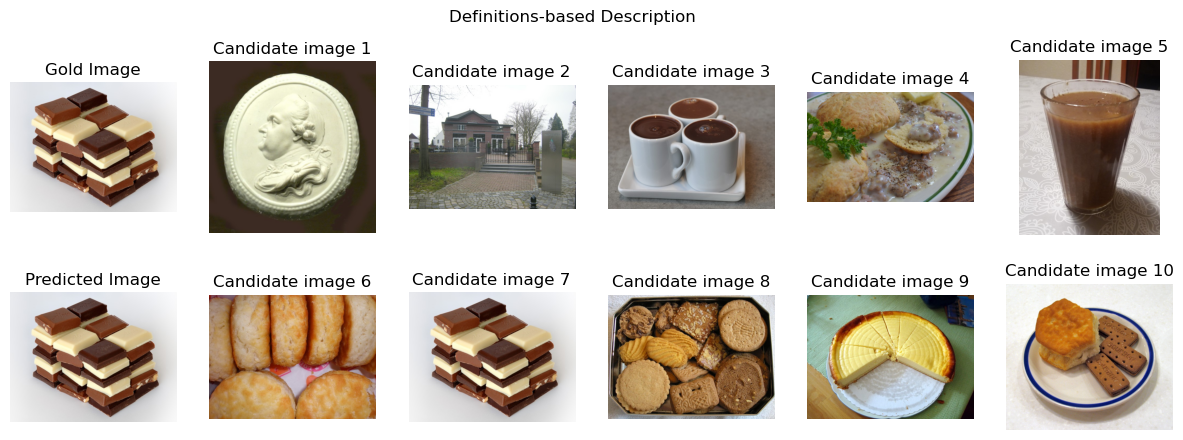

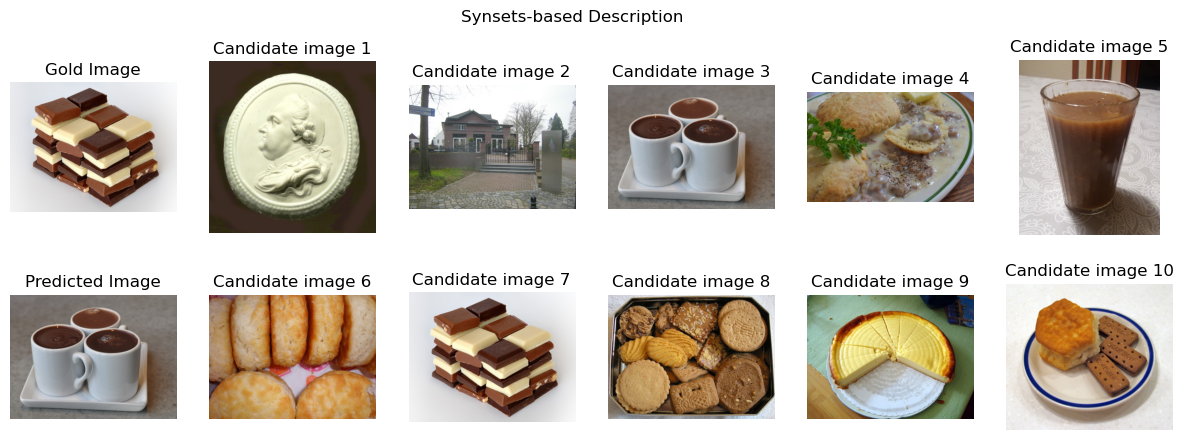

In [21]:
index = test_df[test_df['translated_full_phrase'] == 'chocolate chunk'].index[0]
row = test_df.iloc[index]

most_similar_image_d, similarity_d, is_correct_d = predict_image(test_df, index, test_images_path, model, preprocess, 'definitions', True, device)
most_similar_image_s, similarity_s, is_correct_s = predict_image(test_df, index, test_images_path, model, preprocess, 'synsets', True, device)

print(f'target_word:                  {row["target_word"]}')
print(f'full_phrase:                  {row["translated_full_phrase"]}')
print(f'gold_image:                   {row["gold_image"]}')
print(f'definition_based_description: {row["definitions_based_description_text"]}, {row["definitions_based_description_weight"]}, {most_similar_image_d}, {similarity_d}, {is_correct_d}')
print(f'synsets_based_description:    {row[f"synsets_based_description_text"]}, {row[f"synsets_based_description_weight"]}, {most_similar_image_s}, {similarity_s}, {is_correct_s}')



fig, ax = plt.subplots(2, 6, figsize=(15, 5))
fig.suptitle('Definitions-based Description')

for i in range(2):
    for j in range(6):
        ax[i, j].axis('off')

ax[0, 0].imshow(Image.open(test_images_path + row['gold_image']))
ax[0, 0].set_title('Gold Image')

ax[1, 0].imshow(Image.open(test_images_path + most_similar_image_d))
ax[1, 0].set_title('Predicted Image')

for i in range(1, 6):
    ax[0, i].imshow(Image.open(test_images_path + row[f'image_{i}']))
    ax[0, i].set_title(f'Candidate image {i}')
    ax[1, i].imshow(Image.open(test_images_path + row[f'image_{i+5}']))
    ax[1, i].set_title(f'Candidate image {i+5}')

plt.show()

fig, ax = plt.subplots(2, 6, figsize=(15, 5))
fig.suptitle('Synsets-based Description')

for i in range(2):
    for j in range(6):
        ax[i, j].axis('off')

ax[0, 0].imshow(Image.open(test_images_path + row['gold_image']))
ax[0, 0].set_title('Gold Image')

ax[1, 0].imshow(Image.open(test_images_path + most_similar_image_s))
ax[1, 0].set_title('Predicted Image')

for i in range(1, 6):
    ax[0, i].imshow(Image.open(test_images_path + row[f'image_{i}']))
    ax[0, i].set_title(f'Candidate image {i}')
    ax[1, i].imshow(Image.open(test_images_path + row[f'image_{i+5}']))
    ax[1, i].set_title(f'Candidate image {i+5}')

plt.show()

### Results

In [ ]:
COMPUTE_RESULTS = False

#### Synset-based results

In [ ]:
#* TRANSLATED = True, DESCRIPTION = 'synsets'

if COMPUTE_RESULTS:

    corrects_en = compute_results(test_df, 'en', test_images_path, model, preprocess, translated=True, description='synsets', device=device)
    print('-'*50)
    corrects_it = compute_results(test_df, 'it', test_images_path, model, preprocess, translated=True, description='synsets', device=device)
    print('-'*50)
    corrects_fa = compute_results(test_df, 'fa', test_images_path, model, preprocess, translated=True, description='synsets', device=device)
    print('-'*50)

    print(f'Overall accuracy: {(corrects_en + corrects_it + corrects_fa)/len(test_df)}')

In [ ]:
#* TRANSLATED = False, DESCRIPTION = 'synsets'

if COMPUTE_RESULTS:

    corrects_en = compute_results(test_df, 'en', test_images_path, model, preprocess, translated=False, description='synsets', device=device)
    print('-'*50)
    corrects_it = compute_results(test_df, 'it', test_images_path, model, preprocess, translated=False, description='synsets', device=device)
    print('-'*50)
    corrects_fa = compute_results(test_df, 'fa', test_images_path, model, preprocess, translated=False, description='synsets', device=device)
    print('-'*50)

    print(f'Overall accuracy: {(corrects_en + corrects_it + corrects_fa)/len(test_df)}')

#### Definition-based results

In [ ]:
#* TRANSLATED = True, DESCRIPTION = 'definitions'

if COMPUTE_RESULTS:

    corrects_en = compute_results(test_df, 'en', test_images_path, model, preprocess, translated=True, description='definitions', device=device)
    print('-'*50)
    corrects_it = compute_results(test_df, 'it', test_images_path, model, preprocess, translated=True, description='definitions', device=device)
    print('-'*50)
    corrects_fa = compute_results(test_df, 'fa', test_images_path, model, preprocess, translated=True, description='definitions', device=device)
    print('-'*50)

    print(f'Overall accuracy: {(corrects_en + corrects_it + corrects_fa)/len(test_df)}')

In [ ]:
#* TRANSLATED = False, DESCRIPTION = 'definitions'

if COMPUTE_RESULTS:

    corrects_en = compute_results(test_df, 'en', test_images_path, model, preprocess, translated=False, description='definitions', device=device)
    print('-'*50)
    corrects_it = compute_results(test_df, 'it', test_images_path, model, preprocess, translated=False, description='definitions', device=device)
    print('-'*50)
    corrects_fa = compute_results(test_df, 'fa', test_images_path, model, preprocess, translated=False, description='definitions', device=device)
    print('-'*50)

    print(f'Overall accuracy: {(corrects_en + corrects_it + corrects_fa)/len(test_df)}')

#### No-description results

In [ ]:
#* TRANSLATED = True, DESCRIPTION = 'none'

if COMPUTE_RESULTS:

    corrects_en = compute_results(test_df, 'en', test_images_path, model, preprocess, translated=True, description='none', device=device)
    print('-'*50)
    corrects_it = compute_results(test_df, 'it', test_images_path, model, preprocess, translated=True, description='none', device=device)
    print('-'*50)
    corrects_fa = compute_results(test_df, 'fa', test_images_path, model, preprocess, translated=True, description='none', device=device)
    print('-'*50)

    print(f'Overall accuracy: {(corrects_en + corrects_it + corrects_fa)/len(test_df)}')

In [ ]:
#* TRANSLATED = False, DESCRIPTION = 'none'

if COMPUTE_RESULTS:

    corrects_en = compute_results(test_df, 'en', test_images_path, model, preprocess, translated=False, description='none', device=device)
    print('-'*50)
    corrects_it = compute_results(test_df, 'it', test_images_path, model, preprocess, translated=False, description='none', device=device)
    print('-'*50)
    corrects_fa = compute_results(test_df, 'fa', test_images_path, model, preprocess, translated=False, description='none', device=device)
    print('-'*50)

    print(f'Overall accuracy: {(corrects_en + corrects_it + corrects_fa)/len(test_df)}')

#### Accuracies

In [ ]:
# COMPUTE ACCURACY

# ------------------------------------------------------------------------------------------------------------------------------------ #
#* SYNSETS BASED SOLUTIONS
gt_images_en   = 'Datasets/Test/en.test.gold.txt'
gt_images_it   = 'Datasets/Test/it.test.gold.txt'
gt_images_fa  = 'Datasets/Test/fa.test.gold.txt'

#* TRANSLATED = True, DESCRIPTION = 'synsets', LANGUAGE = en
pred_images = 'Datasets/Test/synsets_based_solutions/preds_translated_description/en.test.preds.txt'
correct_en, total_en = compute_correct_predictions(pred_images, gt_images_en)
print(f'Language: en, Description: synsets, Translated: True -- Accuracy: {correct_en/total_en:.4f}')

#* TRANSLATED = True, DESCRIPTION = 'synsets', LANGUAGE = it
pred_images = 'Datasets/Test/synsets_based_solutions/preds_translated_description/it.test.preds.txt'
correct_it, total_it = compute_correct_predictions(pred_images, gt_images_it)
print(f'Language: it, Description: synsets, Translated: True -- Accuracy: {correct_it/total_it:.4f}')

#* TRANSLATED = True, DESCRIPTION = 'synsets', LANGUAGE = fa
pred_images = 'Datasets/Test/synsets_based_solutions/preds_translated_description/fa.test.preds.txt'
correct_fa, total_fa = compute_correct_predictions(pred_images, gt_images_fa)
print(f'Language: fa, Description: synsets, Translated: True -- Accuracy: {correct_fa/total_fa:.4f}')

print(f'Weighted average accuracy: {(correct_en + correct_it + correct_fa)/(total_en + total_it + total_fa):.4f}')

print()

#* TRANSLATED = False, DESCRIPTION = 'synsets', LANGUAGE = en
pred_images = 'Datasets/Test/synsets_based_solutions/preds_description/en.test.preds.txt'
correct_en, total_en = compute_correct_predictions(pred_images, gt_images_en)
print(f'Language: en, Description: synsets, Translated: False -- Accuracy: {correct_en/total_en:.4f}')

#* TRANSLATED = False, DESCRIPTION = 'synsets', LANGUAGE = it
pred_images = 'Datasets/Test/synsets_based_solutions/preds_description/it.test.preds.txt'
correct_it, total_it = compute_correct_predictions(pred_images, gt_images_it)
print(f'Language: it, Description: synsets, Translated: False -- Accuracy: {correct_it/total_it:.4f}')

#* TRANSLATED = False, DESCRIPTION = 'synsets', LANGUAGE = fa
pred_images = 'Datasets/Test/synsets_based_solutions/preds_description/fa.test.preds.txt'
correct_fa, total_fa = compute_correct_predictions(pred_images, gt_images_fa)
print(f'Language: fa, Description: synsets, Translated: False -- Accuracy: {correct_fa/total_fa:.4f}')

print(f'Weighted average accuracy: {(correct_en + correct_it + correct_fa)/(total_en + total_it + total_fa):.4f}')

print('-'*100)
print()

# ------------------------------------------------------------------------------------------------------------------------------------ #
#* DEFINITIONS BASED SOLUTIONS

#* TRANSLATED = True, DESCRIPTION = 'definitions', LANGUAGE = en
pred_images = 'Datasets/Test/definitions_based_solutions/preds_translated_description/en.test.preds.txt'
correct_en, total_en = compute_correct_predictions(pred_images, gt_images_en)
print(f'Language: en, Description: definitions, Translated: True -- Accuracy: {correct_en/total_en:.4f}')

#* TRANSLATED = True, DESCRIPTION = 'definitions', LANGUAGE = it
pred_images = 'Datasets/Test/definitions_based_solutions/preds_translated_description/it.test.preds.txt'
correct_it, total_it = compute_correct_predictions(pred_images, gt_images_it)
print(f'Language: it, Description: definitions, Translated: True -- Accuracy: {correct_it/total_it:.4f}')

#* TRANSLATED = True, DESCRIPTION = 'definitions', LANGUAGE = fa
pred_images = 'Datasets/Test/definitions_based_solutions/preds_translated_description/fa.test.preds.txt'
correct_fa, total_fa = compute_correct_predictions(pred_images, gt_images_fa)
print(f'Language: fa, Description: definitions, Translated: True -- Accuracy: {correct_fa/total_fa:.4f}')

print(f'Weighed average accuracy: {(correct_en + correct_it + correct_fa)/(total_en + total_it + total_fa):.4f}')

print()

#* TRANSLATED = False, DESCRIPTION = 'definitions', LANGUAGE = en
pred_images = 'Datasets/Test/definitions_based_solutions/preds_description/en.test.preds.txt'
correct_en, total_en = compute_correct_predictions(pred_images, gt_images_en)
print(f'Language: en, Description: definitions, Translated: False -- Accuracy: {correct_en/total_en:.4f}')

#* TRANSLATED = False, DESCRIPTION = 'definitions', LANGUAGE = it
pred_images = 'Datasets/Test/definitions_based_solutions/preds_description/it.test.preds.txt'
correct_it, total_it = compute_correct_predictions(pred_images, gt_images_it)
print(f'Language: it, Description: definitions, Translated: False -- Accuracy: {correct_it/total_it:.4f}')

#* TRANSLATED = False, DESCRIPTION = 'definitions', LANGUAGE = fa
pred_images = 'Datasets/Test/definitions_based_solutions/preds_description/fa.test.preds.txt'
correct_fa, total_fa = compute_correct_predictions(pred_images, gt_images_fa)
print(f'Language: fa, Description: definitions, Translated: False -- Accuracy: {correct_fa/total_fa:.4f}')

print(f'Weighed average accuracy: {(correct_en + correct_it + correct_fa)/(total_en + total_it + total_fa):.4f}')

print('-'*100)
print()

# ------------------------------------------------------------------------------------------------------------------------------------ #
#* NO DESCRIPTION

#* TRANSLATED = True, DESCRIPTION = 'none', LANGUAGE = en
pred_images = 'Datasets/Test/synsets_based_solutions/preds_translated/en.test.preds.txt'
correct_en, total_en = compute_correct_predictions(pred_images, gt_images_en)
print(f'Language: en, Description: none, Translated: True -- Accuracy: {correct_en/total_en:.4f}')

#* TRANSLATED = True, DESCRIPTION = 'none', LANGUAGE = it
pred_images = 'Datasets/Test/synsets_based_solutions/preds_translated/it.test.preds.txt'
correct_it, total_it = compute_correct_predictions(pred_images, gt_images_it)
print(f'Language: it, Description: none, Translated: True -- Accuracy: {correct_it/total_it:.4f}')

#* TRANSLATED = True, DESCRIPTION = 'none', LANGUAGE = fa
pred_images = 'Datasets/Test/synsets_based_solutions/preds_translated/fa.test.preds.txt'
correct_fa, total_fa = compute_correct_predictions(pred_images, gt_images_fa)
print(f'Language: fa, Description: none, Translated: True -- Accuracy: {correct_fa/total_fa:.4f}')

print(f'Weighed average accuracy: {(correct_en + correct_it + correct_fa)/(total_en + total_it + total_fa):.4f}')

print()

#* TRANSLATED = False, DESCRIPTION = 'none', LANGUAGE = en
pred_images = 'Datasets/Test/synsets_based_solutions/preds/en.test.preds.txt'
correct_en, total_en = compute_correct_predictions(pred_images, gt_images_en)
print(f'Language: en, Description: none, Translated: False -- Accuracy: {correct_en/total_en:.4f}')

#* TRANSLATED = False, DESCRIPTION = 'none', LANGUAGE = it
pred_images = 'Datasets/Test/synsets_based_solutions/preds/it.test.preds.txt'
correct_it, total_it = compute_correct_predictions(pred_images, gt_images_it)
print(f'Language: it, Description: none, Translated: False -- Accuracy: {correct_it/total_it:.4f}')

#* TRANSLATED = False, DESCRIPTION = 'none', LANGUAGE = fa
pred_images = 'Datasets/Test/synsets_based_solutions/preds/fa.test.preds.txt'
correct_fa, total_fa = compute_correct_predictions(pred_images, gt_images_fa)
print(f'Language: fa, Description: none, Translated: False -- Accuracy: {correct_fa/total_fa:.4f}')

print(f'Weighed average accuracy: {(correct_en + correct_it + correct_fa)/(total_en + total_it + total_fa):.4f}')